In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from IPython.display import display, HTML

### Principal Component Analysis 

Why do PCA?

 - Principal components analysis is an unsupervised learning method where we do not work with labels to study data, i.e., only explanatory features **X** are considered.
   - Unlike supervised learning, e.g. regression analysis which has a response **y** to predict, the goal of unsupervised learning is to determine a relationship between features **X** and response **y**.   
 - Principal components are directions of vectors in which the data set vary the most in terms of the **X** features space.
  - An alternative interpretation of PCAs are as vectors which correspond ***as close as possible*** to the cloud of **X** features data.   
 - PCA is useful as a method to reduce the dimension of features when there exist many features and we are unsure which features are important.
   - In this sense, PCA can be viewed as a method for exploratory data analysis because we can compute PCs and visualize the vectors which have the highest variance in feature space. 

### Import Lahman Baseball Data and Select Features
  - omit dependent, common features

In [120]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the data files
downloaded = drive.CreateFile({'id':'1_D_mKJVsDqTkVnr2FNSVMdAHGEHaq1JM'})
downloaded.GetContentFile('Teams.csv')  

def lahman_year_team(inputdf,yr='2016',droplist=['yearID','G','Ghome','W','L','Rank']):
    '''
    function which obtains numeric-only data from Lahman Teams data set and selects year
    inputdf    : Lahman Teams.csv, DataFrame
    yr         : year to select, int
    droplist   : constant (e.g. games played are same across teams) features to omit from returned data, list of str
    returns    : numeric Teams features with team_id as index, DataFrame
    '''
    df = inputdf.copy()
    # select numeric data only for PCA
    numericdf = df.select_dtypes(exclude=['object'])
    # assign team_ID as index
    numericdf.set_index(df['teamID'].values,inplace=True)
    # filter by year
    numericdf = numericdf[numericdf.yearID==yr]
    # drop constant features, where value is dependent or does not vary by player/team performance
    numericdf.drop(droplist,axis=1,inplace=True)
    print('Lahman numeric feature team results {}:'.format(yr))
    return numericdf 

teamsdf = pd.read_csv('Teams.csv')
droplist=['yearID','G','Ghome','W','L','Rank']
teams15 = lahman_year_team(teamsdf,yr=2015,droplist=droplist)    
teams15.head()

Lahman numeric feature team results 2015:


R    AB     H   2B  3B   HR   BB      SO     SB    CS ...     HA  HRA  \
ARI  720  5649  1494  289  48  154  490  1312.0  132.0  44.0 ...   1450  182   
ATL  573  5420  1361  251  18  100  471  1107.0   69.0  33.0 ...   1462  170   
BAL  713  5485  1370  246  20  217  418  1331.0   44.0  25.0 ...   1406  174   
BOS  748  5640  1495  294  33  161  478  1148.0   71.0  27.0 ...   1486  178   
CHA  622  5533  1381  260  27  136  404  1231.0   68.0  42.0 ...   1443  162   

     BBA   SOA    E     DP     FP  attendance  BPF  PPF  
ARI  500  1215   86  146.0  0.986   2080145.0  107  106  
ATL  550  1148   90  186.0  0.985   2001392.0   97   97  
BAL  483  1233   77  134.0  0.987   2281202.0  103  104  
BOS  478  1218   97  148.0  0.984   2880694.0  104  107  
CHA  474  1359  101  159.0  0.983   1755810.0   92   93  

[5 rows x 29 columns]

## PCA from Scratch

- step 1: center and scale the features matrix
- step 2: compute covariance matrix of centered features
- step 3: compute tuple eigenvalues, eigenvectors using np.linalg.eig(X)
  - eigenvectors are the principal component loading vectors, which are the directions of highest variation within the feature space X
- step 4: compute the Principal Components by projecting the centered X features onto the PC loading eigenvectors
  - PC_Matrix = LoadingVector dotproduct centeredFeatures 

In [121]:
def center_scale(X):
    '''
    returns : X features centered by column mean and scaled by column std, df
    '''
    return (X-np.mean(X))/np.std(X)

def pca(inputdf):
    '''
    function which computes largest variance directions (loading vectors) and principal components (score vectors)
    inputdf    : features to compute variance explained
    returns    : loading vectors, score vectors as PCs, variance explained as eigenvals    
    '''
    df = inputdf.copy()
    # step 1: center/scale the features
    C = center_scale(df)
    print('Shape of centered features matrix = {}'.format(C.shape))
    # step 2: compute cov of tranpsose of centered features
    cov = np.cov(C.T)
    print('shape of covariance matrix = {}'.format(cov.shape))
    # step 3: compute the PC loading vectors (direction of largest variacne in features space)
    eigvals,eigvecs = np.linalg.eig(cov)
    print('shape of eigenvalues, eigenvectors = {}, {}'.format(eigvals.shape,eigvecs.shape))
    loadingheaders = ['L'+str(i) for i in range(1,len(df.columns)+1)]
    # eigvecs are loadings 
    loadingdf = pd.DataFrame(eigvecs,columns=loadingheaders,index=df.columns).astype(float)
    print('shape of loadings df = {}'.format(loadingdf.shape))
    print('Top 5 PC loading vectors (direction of largest variation in feature-space):')
    display(loadingdf.loc[:,:'L5'])
    # step 4: compute score vectors as Principal Components (where scores are features C projected onto loading vectors)
    scorematrix = loadingdf.values.T.dot(C.T)
    scoreheaders = ['PC'+str(i) for i in range(1,len(C.columns)+1)]
    scoredf = pd.DataFrame(scorematrix.T,index=C.index,columns=scoreheaders)
    display(scoredf.head())
    return loadingdf,scoredf,eigvals


loadingdf,scoredf,eigvals = pca(teams15)


Shape of centered features matrix = (30, 29)
shape of covariance matrix = (29, 29)
shape of eigenvalues, eigenvectors = (29,), (29, 29)
shape of loadings df = (29, 29)
Top 5 PC loading vectors (direction of largest variation in feature-space):


L1        L2        L3        L4        L5
R           0.017276 -0.386149  0.232467  0.203736  0.019979
AB         -0.138596 -0.305516 -0.196406  0.127001 -0.090432
H          -0.140925 -0.382826 -0.049577 -0.123020 -0.180755
2B          0.044716 -0.405611 -0.024892  0.049429 -0.157346
3B         -0.187099 -0.155353 -0.191339 -0.277659 -0.043228
HR          0.088132 -0.123332  0.309474  0.221520  0.214984
BB          0.201950 -0.160387  0.198059  0.163042 -0.104419
SO          0.096753  0.061363 -0.050595  0.120502  0.285352
SB         -0.101238 -0.210840 -0.142246 -0.190592  0.001263
CS         -0.066925 -0.037749 -0.270469 -0.281125 -0.032331
HBP         0.193408 -0.094755 -0.252292  0.156713  0.131542
SF          0.046544 -0.318393  0.135119  0.079944  0.055133
RA         -0.325051  0.068192  0.071362  0.150924 -0.013619
ER         -0.329468  0.063327  0.081393  0.106130  0.003279
ERA        -0.329352  0.076757  0.100441  0.090926  0.002646
CG          0.034948 -0.102367  0.221413 -0.003810 -0.437085
SHO         0.228067  0.004482 -0.068145 -0.181208 -0.259860
SV          0.192469 -0.067604 -0.215381 -0.084683  0.344455
IPouts      0.153951 -0.195590 -0.308017  0.134359  0.033228
HA         -0.294854  0.008911 -0.066495  0.121956  0.058458
HRA        -0.252076  0.025461  0.206098  0.183209  0.003866
BBA        -0.267883  0.067176 -0.152606 -0.054066  0.193934
SOA         0.237456  0.091807 -0.031918  0.084829  0.166325
E          -0.057073 -0.026589 -0.320449  0.442468 -0.028033
DP         -0.180437 -0.042690 -0.210836 -0.046859 -0.195318
FP          0.056503  0.009746  0.307108 -0.441010  0.050444
attendance  0.123788 -0.123704  0.071312 -0.004365  0.037997
BPF        -0.126030 -0.248223  0.100125 -0.206072  0.368725
PPF        -0.160965 -0.245601  0.101642 -0.131604  0.382194

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
ARI -2.151701 -3.565630 -0.638577 -1.511943  0.834343  1.743422  0.403318   
ATL -2.441920  3.857828 -0.246907 -0.752083 -1.060399 -1.865924  0.313098   
BAL -0.102237  1.933125  2.408239  0.063009  2.461828 -0.652012 -1.178688   
BOS -2.330114 -2.350229  0.733453  0.957053 -0.095163 -1.257763 -1.087311   
CHA -0.249243  2.222028 -1.687861  0.902486 -1.735683  0.390556  0.686454   

          PC8       PC9      PC10    ...         PC20      PC21      PC22  \
ARI  1.188761 -0.936199  0.357344    ...    -0.137598  0.354221  0.086151   
ATL -0.504441  0.042887 -2.319832    ...     0.099854 -0.075625 -0.039260   
BAL  0.496656  0.352908  0.658029    ...    -0.294805 -0.007775  0.176848   
BOS -0.323003 -1.176090  0.441068    ...    -0.044000 -0.273940 -0.236007   
CHA  0.770309 -0.647574 -0.734283    ...    -0.354634  0.192300  0.105892   

         PC23      PC24      PC25      PC26      PC27      PC28      PC29  
ARI -0.092396  0.013825  0.053595 -0.041574 -0.033268 -0.000526 -0.041990  
ATL -0.036473 -0.125948  0.048266 -0.105751 -0.009150  0.000142 -0.029596  
BAL -0.005883  0.052619 -0.127703  0.041432  0.023878  0.000148 -0.033171  
BOS -0.439200 -0.114835 -0.027033  0.047095  0.023130  0.000050  0.022042  
CHA -0.163167  0.007403  0.071427 -0.096571  0.041464 -0.000365  0.013093  

[5 rows x 29 columns]

### Plot Percent Variance Explained

- Each loading vector (eigenvector) and principal component (score vector) has a corresponding eigenvalue, which equals the sample variance of each directional score vector   
- The cumulative PVE indicates that approximately 90% of the variation of the features is explained by the first 10 principal components 

array([0.28188393, 0.41839102, 0.53829927, 0.61803049, 0.68224135,
       0.73940516, 0.78711524, 0.83235342, 0.86223893, 0.89019109,
       0.91462212, 0.93597454, 0.95230898, 0.96352917, 0.97424114,
       0.98251066, 0.9886374 , 0.99224027, 0.99448964, 0.99622887,
       0.99760415, 0.99847513, 0.99902236, 0.99947662, 0.99979894,
       0.99991828, 0.99997957, 0.99997957, 1.        ])

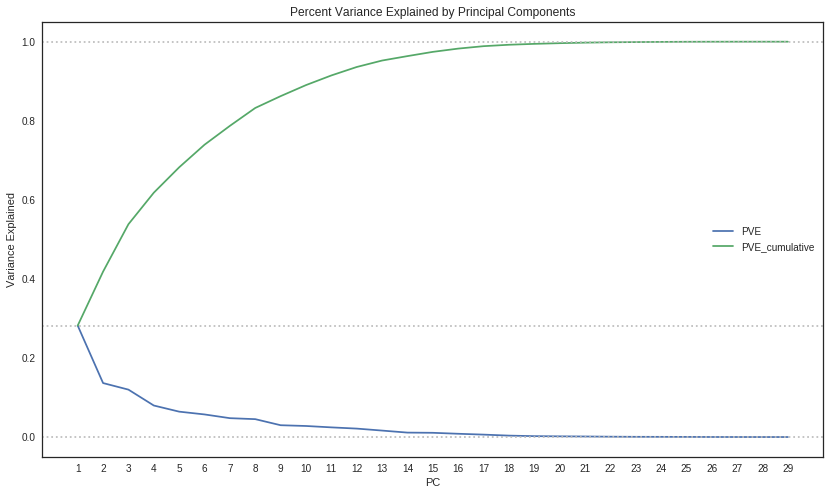

In [122]:
def pve(eigvals):
    '''
    function which computes percent variance explained (PVE), cumulative PVE of all PCs
    inputdf     : numeric features X with named indices, DataFrame
    eigvals     : eigenvalues resulting from principal components analyis, are the corresponding variance explained of ea. PC
    '''
#     plt.style.use('seaborn-pastel')
    with plt.style.context('seaborn-white'):
        fig,ax = plt.subplots(figsize=(14,8))
        var_total = eigvals.sum()
        # compute proportional variance explained per PC
        pve = eigvals/var_total
        # compute cum. variance explained per PC
        cumpve = np.cumsum(pve)
        x = [i for i in range(1,len(eigvals)+1)]
        ax.set_xticks(x)
        ax.plot(x,pve,label='PVE')
        ax.plot(x,cumpve,label='PVE_cumulative')
        ax.set(title='Percent Variance Explained by Principal Components',
              xlabel='PC',ylabel='Variance Explained')
        # ref lines
        hlinecolor='0.74'
        ax.axhline(y=eigvals[0]/eigvals.sum(),linestyle='dotted',color=hlinecolor)
        ax.axhline(y=0,linestyle='dotted',color=hlinecolor)
        ax.axhline(y=1,linestyle='dotted',color=hlinecolor)
        ax.legend(loc='best')
pve(eigvals)

np.cumsum(eigvals/eigvals.sum())

## Biplot to Visualize First Two PCs Explaining Largest Variation of Data 
 - loading vectors reveal directions with largest variation in feature space
 - score vectors (features X projected onto loading direction vectors) reveal features in correspondence with vector directions with highest variance
 

2015 Final MLB Team Standings:


teamID lgID divID   W   L  Rank
6     KCA   AL     C  95  67     1
14    TOR   AL     E  93  69     1
13    TEX   AL     W  88  74     1
8     MIN   AL     C  83  79     2
9     NYA   AL     E  87  75     2
5     HOU   AL     W  86  76     2
3     CLE   AL     C  81  80     3
0     BAL   AL     E  81  81     3
7     LAA   AL     W  85  77     3
2     CHA   AL     C  76  86     4
12    TBA   AL     E  80  82     4
11    SEA   AL     W  76  86     4
4     DET   AL     C  74  87     5
1     BOS   AL     E  78  84     5
10    OAK   AL     W  68  94     5

teamID lgID divID    W   L  Rank
13    SLN   NL     C  100  62     1
8     NYN   NL     E   90  72     1
5     LAN   NL     W   92  70     1
10    PIT   NL     C   98  64     2
14    WAS   NL     E   83  79     2
12    SFN   NL     W   84  78     2
2     CHN   NL     C   97  65     3
6     MIA   NL     E   71  91     3
0     ARI   NL     W   79  83     3
7     MIL   NL     C   68  94     4
1     ATL   NL     E   67  95     4
11    SDN   NL     W   74  88     4
3     CIN   NL     C   64  98     5
9     PHI   NL     E   63  99     5
4     COL   NL     W   68  94     5

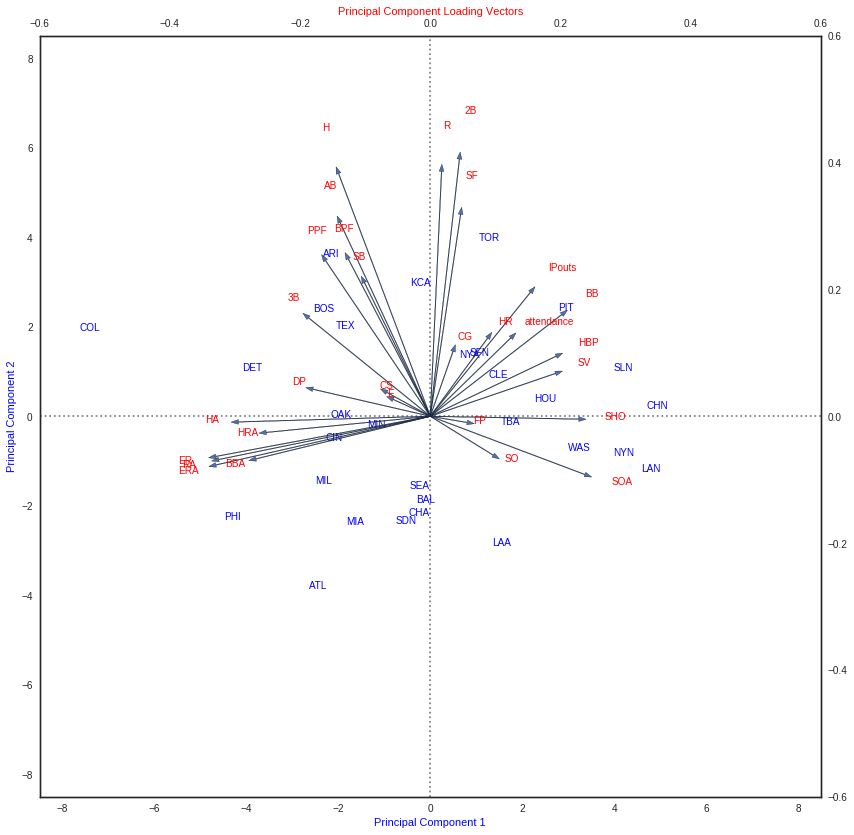

In [124]:
def lg_ranks(inputdf,year):
    '''
    function which displays team end of season results
    inputdf    : Lahman database Teams.csv, DataFrame
    year       : year to filter, int
    '''
    df = inputdf.copy()
    algrp = df[(df.yearID==year)&(df.lgID=='AL')].groupby(['teamID','lgID','divID','W','L'],as_index=False).agg({'Rank':'last'}).sort_values(['Rank','lgID','divID'])
    nlgrp = df[(df.yearID==year)&(df.lgID=='NL')].groupby(['teamID','lgID','divID','W','L'],as_index=False).agg({'Rank':'last'}).sort_values(['Rank','lgID','divID'])
    print('{} Final MLB Team Standings:'.format(year))
    return algrp,nlgrp

def biplot(loadingdf,scoredf,loading_color,score_color,score_axlim=7.5,load_axlim=7.5,load_arrows=4):
    '''
    function which computes biplot of PC scores, loadings
    scoredf    : matrix of PC score vectors, used tp display how indices are projected onto PC loading vectors, DataFrame
    loadingdf  : matrix of PC loading vectors from centered, std'd features, used to show actual direction of PC1 and PC2 2D vectors, DataFrame
    _color     : matplotlib line colors for corresponding loading vectors, score projection points, str
    '''
    with plt.style.context('seaborn-white'):
        f = plt.figure(figsize=(14,14))
        ax0 = plt.subplot(111)
        # plot the first two score vectors, as annotations, of teamID indices (PC1,PC2 are orhogonal to ea. other)
        for teamid in scoredf.index:  
            ax0.annotate(teamid,(scoredf['PC1'][teamid],-scoredf['PC2'][teamid]),ha='center',color=score_color)
        score_axlim = score_axlim
        ax0.set(xlim=(-score_axlim,score_axlim),ylim=(-score_axlim,score_axlim),
               )
        ax0.set_xlabel('Principal Component 1',color=score_color)
        ax0.set_ylabel('Principal Component 2',color=score_color)
        # add reference lines through origin
        ax0.hlines(y=0,xmin=-score_axlim,xmax=score_axlim,linestyle='dotted',color='grey')
        ax0.vlines(x=0,ymin=-score_axlim,ymax=score_axlim,linestyle='dotted',color='grey')
        # plot PC1 and PC2 loadings (two directions in features space with largest variation) as reference vectors
        ax1 = ax0.twinx().twiny()
        ax1.set(xlim=(-load_axlim,load_axlim), ylim=(-load_axlim,load_axlim),
               )
        ax1.tick_params(axis='y',color='red')
        ax1.set_xlabel('Principal Component Loading Weights',color=loading_color)
        # plot first two PC loading vectors (as loadingdf.index annotations)
        offset_scalar=1.175
        for feature in loadingdf.index: 
            ax1.annotate(feature,(loadingdf['L1'].loc[feature]*offset_scalar,-loadingdf['L2'].loc[feature]*offset_scalar),color=loading_color)
        # display first fourPCs as arrows
        # matplotlib.pyplot.arrow(x, y, dx, dy, hold=None, **kwargs)  # e.g. kwargs 0.015,shape='full')
        for i in range(0,load_arrows):
            ax1.arrow(x=0,y=0,dx=loadingdf['L1'][i],dy=-loadingdf['L2'][i],head_width=0.0075,shape='full')

biplot(loadingdf,scoredf,loading_color='red',score_color='blue',score_axlim=8.5,load_axlim=.6,load_arrows=len(loadingdf.columns))        
ALrankdf,NLrankdf = lg_ranks(teamsdf,2015)
display(ALrankdf)
display(NLrankdf)
    

### Biplot Interpretation

- The first principal component vector (x-axis, blue scoredf indices) for winning teams places the largest weights on: 
  - SOA (strikeouts by pitchers),
  - SHO (shutouts, i.e. no opponent hits),
  - BB (base on balls, i.e. team walks to first base) 
- The first principal component vector for losing teams places the largest weights on:
  - ERA (earned run average),
  - ER (earned runs ),
  - HA (hits allowed),
   
- The second principal component (y-axis, blue scoredf indices) for winning teams places the highest weights on:
   - Runs (number of points scored),
   - 2B (doubles),
   - H (hits)
   
- The teamID indices (blue) of the score vectors reveal:
  - Winning (losing) teams on the right-hand (left-hand) side of the biplot
  - The Los Angeles Dodgers (LAN) did well with SOA (strikeouts by pitchers) and SHO (shutouts) which reflects great pitching 
   - Dodgers Pitcher Clayton Kershaw subsequently received $34 million salary by 2018 season (yahoo sports)
 - The New York Yankees (NYA), Cleveland Indians (CLE), San Francisco Giants (SFN), and Pittsburgh Pirates (PIT) did well with HR (home runs), BB (walks by batters), and their owners did well with attendance, i.e. ticket revenues.        
 - The Philadelphia Phillies' (PHI) poor performance coincided with high ERA (earned run average) and BBA (walks allowed).
 - The Oakland Athletics' (OAK), Cincinnatti Reds' (CIN), and Minnesota Twins' (MIN) underperformance coincided with CS (caught stealing) and E (defensive errors), and HRA (home runs allowed). 
      - The Oakland A's subsequently place Matt Chapman at 3B for 2017-2018 and he outperforms on defense as golden glove candidate by 2018 season.  
 - Rather than PC1 winning team attributes, the Toronto Blue Jays did well with R (runs scored), 2B (doubles), SF (sacrifice flies), and H (hits), which reveals that the 2015 Blue Jays outperformed with good offense. 

### Principal Component Analysis with sklearn
 - compute PCA with sklearn to verify manual results above.
 - sklearn returns flipped signs.
 - Sklearn PCA() results are the same as the manual computations above. 

shape of pca.components_ (loadings) = (29, 29)


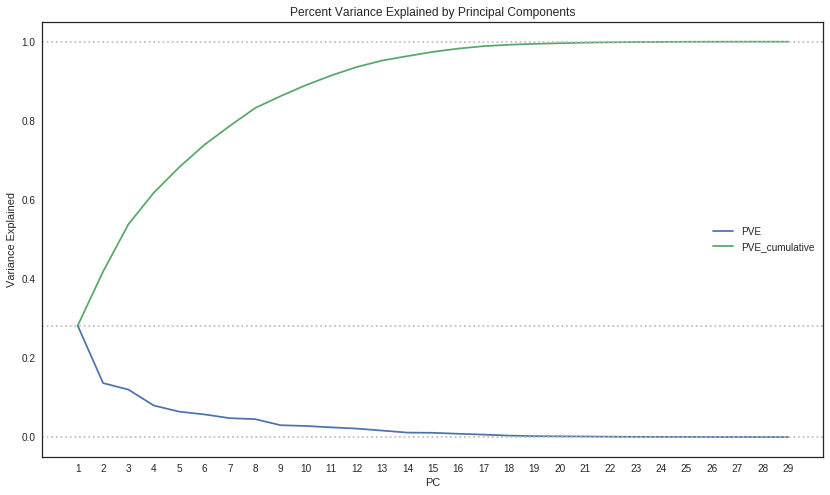

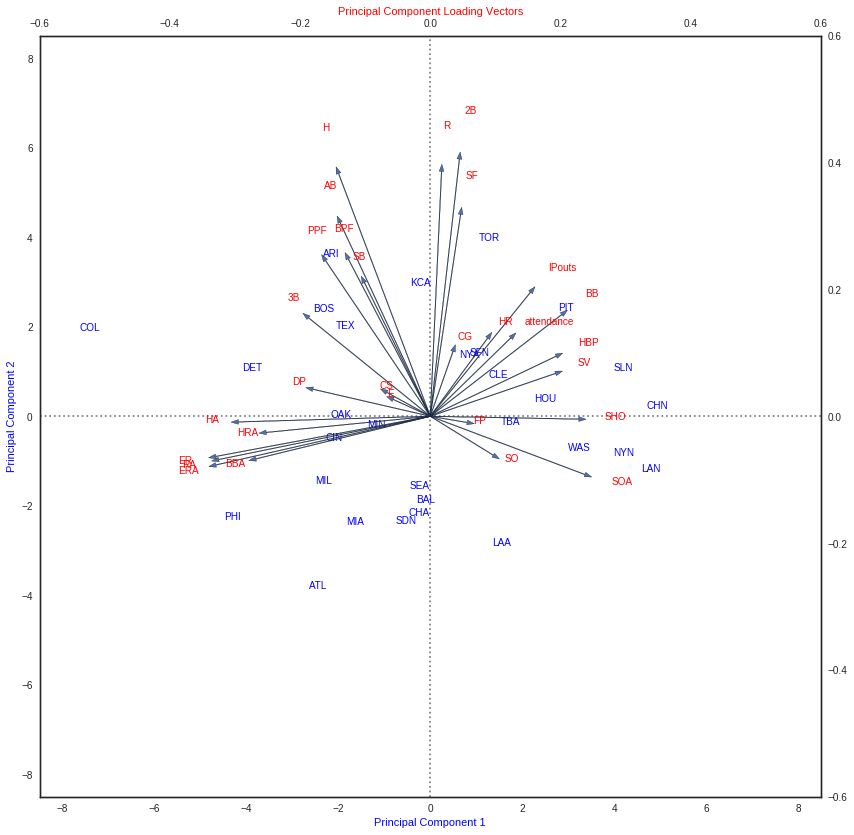

In [125]:
def sklearn_pca(inputdf):
    '''
    function which computes PCA with sklearn libraries
    inputdf    : numeric features X with named indices, DataFrame'''
    from sklearn.preprocessing import scale
    from sklearn.decomposition import PCA
    # step 1: center and scale features X
    C = scale(inputdf)
    C = pd.DataFrame(C,columns=inputdf.columns,index=inputdf.index)
    # step 2: compute loadings as eigenvectors of centered features
    pca = PCA().fit(C)
    # .components_ returned as top p feature loading vecs in each ndarray row 
    loadings_array = pca.components_
    print('shape of pca.components_ (loadings) = {}'.format(loadings_array.shape))
    colnames = ['L'+str(i) for i in range(1,len(inputdf.columns)+1)]
    loadingsdf = pd.DataFrame(loadings_array.T,columns=colnames, index=inputdf.columns)
    # step 3: project features X onto loading vectors as scores (PCs) by calling .fit_transform rather than .fit on PCA obj
    scores_array = pca.fit_transform(C)
    pc_colnames = ['PC'+str(i) for i in range(1,len(C.columns)+1)] 
    scoresdf = pd.DataFrame(scores_array,columns=pc_colnames,index=C.index)
    # get explained_variance_ attribute (eigenvalues of loadings)
    eigenvals = pca.explained_variance_
    return loadingsdf,scoresdf,eigenvals

skloadings,skscores,skeigvals = sklearn_pca(teams15)
pve(skeigvals)
biplot(-1*skloadings,-1*skscores,loading_color='r',score_color='b',score_axlim=8.5,load_axlim=.6,load_arrows=len(loadingdf.columns))
